# CarLane: Experiment Code

preprocess carlane dataset and generate official dataset code

In [17]:
import torch
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline
import random
import json
from PIL import Image, ImageDraw
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
data_path = '../data/2.7万张道路线精细标注抽取2000张/'

## Prepare data

### train val split and get classes

In [4]:
data = os.listdir(data_path)
names = []
for line in data:
    name, t = line.split('.')
    if t == 'jpg':
        names.append(name)
print('total image:{}'.format(len(names)))

val = random.sample(names,100)
train = list(set(names) - set(val))

print('train val split: train:{}, val:{}'.format(len(train), len(val)))

classes = set()
for name in names:
    json_path = data_path + name + '.json'
    annotation = json.load(open(json_path))
    annotation = annotation['datalist']
    for mask in annotation:
        classes.add(mask['type'])
classes = [(c,idx) for idx,c in enumerate(classes,1)]

print('total class:{}'.format(len(classes)))
print(classes)

data_json = {
    'train':train,
    'val':val,
    'classes':classes
}

save_path = data_path+'train_val.json'
json.dump(data_json, open(save_path,'w'))
print('save to: '+ save_path)



total image:2000
train val split: train:1900, val:100
total class:21
[('turn right', 1), ('turn around', 2), ('one', 3), ('sidewalk', 4), ('seven', 5), ('turn left', 6), ('four', 7), ('void', 8), ('route void', 9), ('straight and left', 10), ('stop line', 11), ('straight and right', 12), ('straight and turn around', 13), ('nine', 14), ('straight', 15), ('eight', 16), ('three', 17), ('dotted line', 18), ('zero', 19), ('six', 20), ('solid line', 21)]
save to: ../data/2.7万张道路线精细标注抽取2000张/train_val.json


### Compute Image mean 

In [110]:
mean = np.array([0.0,0.0,0.0])
for name in names:
    image = Image.open(os.path.join(data_path, name+'.jpg'))
    image = np.array(image)
    for i in range(3):
        mean[i] += image[:,:,i].mean()
mean = mean / len(names)     

[ 115.48754211  115.8632623   116.18719119]


In [111]:
mean

array([ 115.48754211,  115.8632623 ,  116.18719119])

## Dataset Code

official code

In [97]:
from mrcnn import utils


class CarlaneDataset(utils.Dataset):
    """
    train_val.json:{
        "train": xx,
        "val":xx,
        "classes":xx
    }
    train, val: [image_name,...]
    classes: [(class_name, class_id),...]
    """

    def load_carlane(self, dataset_dir, subset):
        assert subset in ["train", "val"]
        data = json.load(
            open(os.path.join(dataset_dir, 'train_val.json'), 'r'))

        classes = data['classes']
        for c in classes:
            self.add_class("carlane", c[1], c[0])

        self.class_map = {}
        for c in classes:
            self.class_map[c[0]] = c[1]

        image_names = data[subset]

        # Add images
        for image_name in image_names:
            json_path = os.path.join(dataset_dir, image_name + '.json')
            annotation = json.load(open(json_path))
            annotation = annotation['datalist']
            polygons = [a['arr'] for a in annotation]
            polygons = [[(xy['x'], xy['y']) for xy in p] for p in polygons]
            polygon_types = [a['type'] for a in annotation]

            image_path = os.path.join(dataset_dir, image_name + '.jpg')
            image = Image.open(image_path)
            width, height = image.size

            self.add_image(
                "carlane",
                image_id=image_name,
                path=image_path,
                width=width,
                height=height,
                polygons=polygons,
                polygon_types=polygon_types)

    def load_mask(self, image_id):

        # Convert polygons to a bitmap mask of shape
        # [height, width, insstance_count]
        info = self.image_info[image_id]
        polygons = info["polygons"]
        polygon_types = info["polygon_types"]
        mask = np.zeros([height, width, len(polygons)], dtype=np.uint8)
        for i, polygon in enumerate(polygons):
            m = Image.new('L', (width, height), color=0)
            draw = ImageDraw.Draw(m)
            draw.polygon(polygon, fill=1, outline=1)
            mask[:, :, i] = np.array(m)
        polygon_ids = np.array([self.class_map[t] for t in polygon_types])
        return mask.astype(np.bool), polygon_ids.astype(np.int32)

    def image_reference(self, image_id):

        info = self.image_info[image_id]
        if info["source"] == "carlane":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [98]:
dataset = CarlaneDataset()
dataset.load_carlane(data_path, "train")
dataset.prepare()

In [99]:
mask, mask_type = dataset.load_mask(1)

Text(0.5,1,'18')

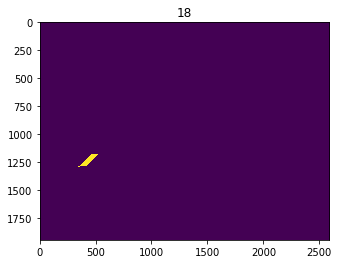

In [100]:
plt.imshow(mask[:,:,0].astype(np.uint8))
plt.title(mask_type[0])

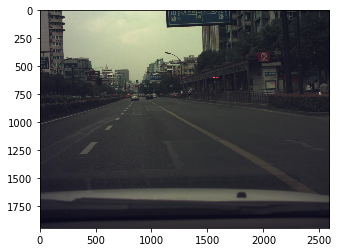

In [101]:
image = dataset.load_image(1)
plt.imshow(image)

## Draft

(2592, 1944)


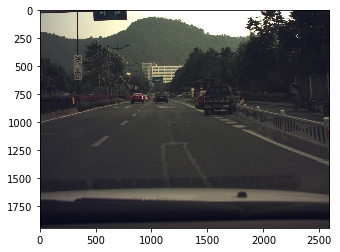

In [21]:
name = names[0]
image_path = os.path.join(data_path, name+'.jpg')
image = Image.open(image_path)
plt.imshow(image)
print(image.size)
width, height = image.size

In [38]:
json_path = os.path.join(data_path, name + '.json')
annotation = json.load(open(json_path))
annotation = annotation['datalist']
polygons = [ a['arr'] for a in annotation]
polygons = [[(xy['x'], xy['y'])for xy in p] for p in polygons]
polygons_type = [ a['type'] for a in annotation]

In [22]:
mask = np.zeros([height, width, len(polygons)], dtype=np.uint8)

In [55]:
for i, polygon in enumerate(polygons):
    m = Image.new('L',(width, height),color=0)
    draw = ImageDraw.Draw(m)
    draw.polygon(polygon, fill=1, outline=1)
    mask[:,:,i] = np.array(m)

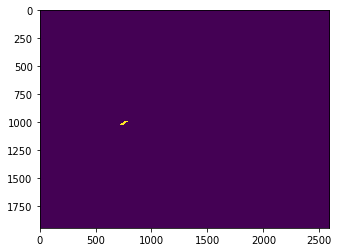

In [58]:
plt.imshow(mask[:,:,1])

In [54]:
np.array(m).max()

1